# Sensitivity Analysis (Uncertainties Sampling)

This notebook performs sesitivity analysis to identify the uncertainities influencing the outcomes of interest. These uncertainities than will be used for formulating scenarios for policy (levers) samping in next step.

In previous analysis, an open exploration was performed to understand the prospect damage if no steps towards flood protectins are taken. The analysis marked dike failure as the biggest threat and Zutphen as the most vulnerable region.
 

Gelderland province priritize the safety of its residents. Thus, the focus of this analysis was set to identify the uncertainities influencing the casualties in the region.

In [1]:
from __future__ import (unicode_literals, print_function, absolute_import, division)
from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario,SequentialEvaluator)
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO)
import time
from problem_formulation import get_model_for_problem_formulation
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
import copy
from ema_workbench import save_results
from ema_workbench import load_results


## MORDM for the optimized policies (pereto set)

In [2]:
# Read optimized policies (pereto set)
optimized_policies = pd.read_csv('policies_for_anmol.csv')
len(optimized_policies)

1045

In [3]:
# Subset policies resulting zero deaths in the Gelderland
optimized_policies = optimized_policies[optimized_policies['A.1_Expected Number of Deaths']+optimized_policies['A.2_Expected Number of Deaths']+optimized_policies['A.3_Expected Number of Deaths'] == 0]

print(f' Number of policies subset resulting zero deaths in the province  = {len(optimized_policies)}')

 Number of policies subset resulting zero deaths in the province  = 31


In [4]:
# Subset policies with 10 percentile RFR cost i.e. 199900000
optimized_policies = optimized_policies[optimized_policies['RfR Total Costs'] <optimized_policies['RfR Total Costs'].quantile(0.1)]
print(f' Number of policies subset resulting least RFR cost (i.e. < 10 percentile)  = {len(optimized_policies)}')

 Number of policies subset resulting least RFR cost (i.e. < 10 percentile)  = 3


In [5]:
optimized_policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.1_Expected Annual Damage,A.1_Dike Investment Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage,A.2_Dike Investment Costs,A.3_Expected Number of Deaths,A.3_Expected Annual Damage,A.3_Dike Investment Costs,RfR Total Costs,Expected Evacuation Costs
439,0,0,1,0,0,0,0,0,0,0,...,0.0,1.449562e+08,0.0,0.0,7.331545e+07,0.0,0.0,1.340357e+08,84600000.0,2425.574742
574,0,0,0,0,0,0,1,0,0,1,...,0.0,6.071731e+07,0.0,0.0,7.331545e+07,0.0,0.0,1.322936e+08,151900000.0,0.000000
1036,0,0,1,0,0,0,1,0,0,0,...,0.0,9.804305e+07,0.0,0.0,1.338442e+08,0.0,0.0,1.322936e+08,115300000.0,0.000000


In [6]:
# Separate levers and outcomes

levers = ['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2',
       '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2',
       '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2']


optimized_policies = optimized_policies.loc[:,levers]

In [7]:
# Format the policies according to ema_workbench sytax List of dicts[{},{},{}]
policies_to_evaluate = []

for index,policy in optimized_policies.iterrows():
    policies_to_evaluate.append(Policy(str(index),**policy.to_dict()))

In [13]:
dike_model, planning_steps = get_model_for_problem_formulation(7)

In [14]:
# dike_model, planning_steps = get_model_for_problem_formulation(7)

# n_scenarios = 1000
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     experiments, outcomes = evaluator.perform_experiments(n_scenarios, policies_to_evaluate)

# save_results((experiments, outcomes), 'optimized_policies_evaluation.tar.gz')

In [15]:
experiments, outcomes = load_results('optimized_policies_evaluation.tar.gz')

[MainProcess/INFO] results loaded succesfully from /Users/anmolsoni/Documents/Documents – Anmol’s MacBook Air/EPA1361/Assignments/epa_1361/final assignment/optimized_policies_evaluation.tar.gz


In [16]:
# Function to calculate signal to noise ratio
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction== 'ScalarOutcome.MAXIMIZE':
        return mean/std
    else:
        return mean*std

In [17]:
# Calculate signal to noise ratio

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in dike_model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.1_Dike Investment Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage,A.2_Dike Investment Costs,A.3_Expected Number of Deaths,A.3_Expected Annual Damage,A.3_Dike Investment Costs,RfR Total Costs,Expected Evacuation Costs
439,9.372650e-09,1.397685e+12,8.640064,7.495137e-07,6.300487e+13,0.000000,0.000001,3.609978e+13,1.997287,0.0,5.144589e+06
574,3.981696e-03,8.545514e+15,0.904758,1.632525e-05,2.012473e+13,0.000000,0.000027,1.313662e+13,0.000000,0.0,0.000000e+00
1036,1.303234e-04,3.423217e+14,2.921911,1.026282e-05,1.154583e+13,7.977736,0.000044,1.959618e+13,0.000000,0.0,0.000000e+00


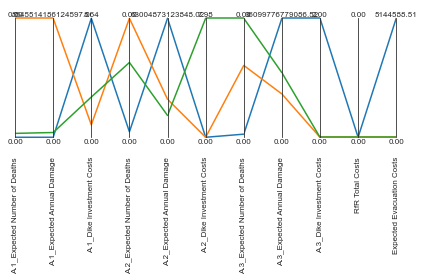

In [37]:
from ema_workbench.analysis import parcoords

data = scores
limits = parcoords.get_limits(data)

limits.iloc[0,:] = 0

paraxes = parcoords.ParallelAxes(limits,fontsize = 8)
paraxes.plot(data)
plt.show()


In [19]:
# Function to calculate max regret
def calculate_regret(data, best):
    return np.abs(best-data)

In [20]:
# Calculate max regret
overall_regret = {}
max_regret = {}
for outcome in dike_model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

<ipython-input-20-4728c941aa07>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()


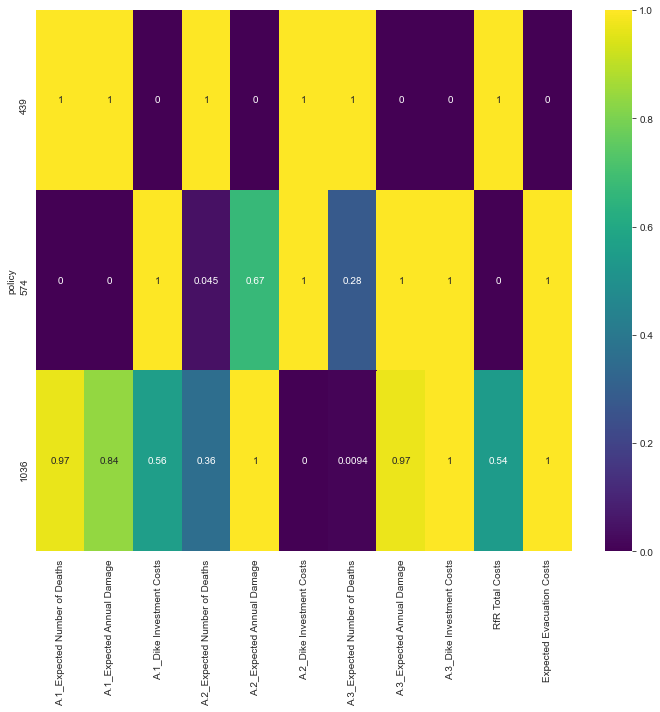

In [65]:
# Plot results of max regret
max_regret = pd.DataFrame(max_regret)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
ax.figure.tight_layout()
plt.show()
fig.savefig('Figures/MORDM/robustness_maxregret.png', dpi=300)

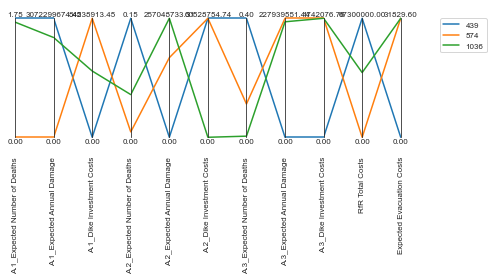

In [67]:
colors = sns.color_palette()

data = max_regret

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, :] = 0

paraxes = parcoords.ParallelAxes(limits, fontsize=8)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()   
plt.show()

Note: Regret for number of deaths is higher in the policy 574 therefore it is not preferred.

In [68]:

from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]
        

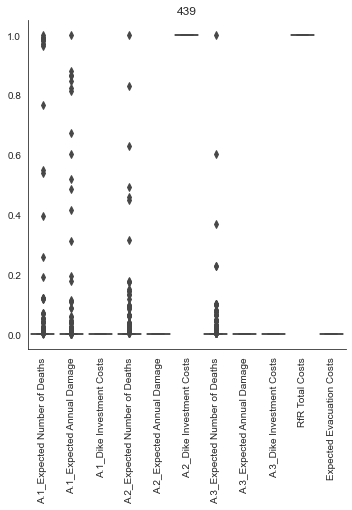

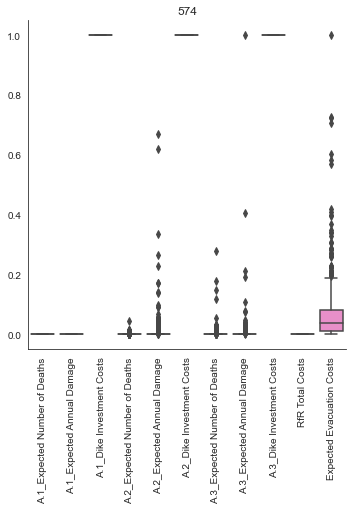

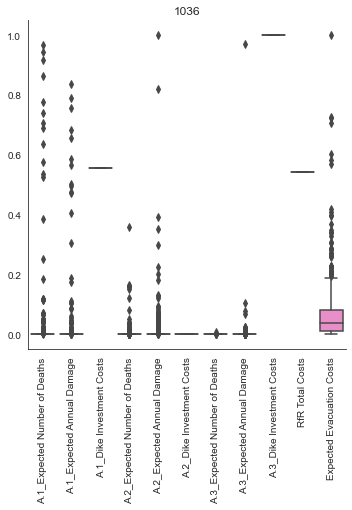

In [72]:


for policy, regret in policy_regret.items():
    data = pd.DataFrame(regret)
    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    fig, ax = plt.subplots(figsize=(5,7))
    sns.boxplot(data=data, ax=ax)
    plt.setp(ax.get_xticklabels(), rotation=90)
    ax.figure.tight_layout()
    # removes top and left hand black outline of axes
    sns.despine()
    # ensure we know which policy the figure is for
    ax.set_title(str(policy))
    fig.savefig(f'Figures/MORDM/{str(policy)}_maxregret.png', dpi=300)

plt.show()


### Selected policy = 574

* 2_RfR 0               1
* 3_RfR 0               1
* A.1_DikeIncrease 0    6
* A.2_DikeIncrease 0    7
* A.3_DikeIncrease 0    7
* A.3_DikeIncrease 1    7
* A.3_DikeIncrease 2    7
* A.3_DikeIncrease 0    7
* A.4_DikeIncrease 0    6
* A.1_DikeIncrease 0    6
* A.2_DikeIncrease 0    7
* A.3_DikeIncrease 0    7
* A.3_DikeIncrease 1    7
* A.3_DikeIncrease 2    7
* A.4_DikeIncrease 0    6
* A.4_DikeIncrease 1    6
* A.4_DikeIncrease 2    7
* A.5_DikeIncrease 0    3
* A.5_DikeIncrease 1    1
* A.5_DikeIncrease 2    4

2_RfR 0               1
3_RfR 0               1
A.1_DikeIncrease 0    6
A.2_DikeIncrease 0    7
A.3_DikeIncrease 0    7
A.3_DikeIncrease 1    7
A.3_DikeIncrease 2    7
A.3_DikeIncrease 0    7
A.4_DikeIncrease 0    6
A.1_DikeIncrease 0    6
A.2_DikeIncrease 0    7
A.3_DikeIncrease 0    7
A.3_DikeIncrease 1    7
A.3_DikeIncrease 2    7
A.4_DikeIncrease 0    6
A.4_DikeIncrease 1    6
A.4_DikeIncrease 2    7
A.5_DikeIncrease 0    3
A.5_DikeIncrease 1    1
A.5_DikeIncrease 2    4

In [187]:
# Subset experiments and outcomes for selected policy
experiments = experiments[experiments.policy == 574]
# 
outcomes = pd.DataFrame.from_dict(outcomes)
outcomes = outcomes[outcomes.index.isin(experiments.index)]

### Identify limiting scenarios (uncertainities) where policy yields undersirable results (failure)

In [205]:
pd.DataFrame.from_dict(outcomes)

,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.1_Dike Investment Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage,A.2_Dike Investment Costs,A.3_Expected Number of Deaths,A.3_Expected Annual Damage,A.3_Dike Investment Costs,RfR Total Costs,Expected Evacuation Costs
1000,0.020072,2.326789e+07,6.071731e+07,0.000000,0.000000e+00,7.331545e+07,0.0,0.0,1.322936e+08,151900000.0,0.0
1001,0.000000,0.000000e+00,6.071731e+07,0.000000,0.000000e+00,7.331545e+07,0.0,0.0,1.322936e+08,151900000.0,0.0
1002,0.000000,0.000000e+00,6.071731e+07,0.029003,2.866808e+07,7.331545e+07,0.0,0.0,1.322936e+08,151900000.0,0.0
1003,0.000000,0.000000e+00,6.071731e+07,0.002472,2.386815e+06,7.331545e+07,0.0,0.0,1.322936e+08,151900000.0,0.0
1004,0.000000,0.000000e+00,6.071731e+07,0.000000,0.000000e+00,7.331545e+07,0.0,0.0,1.322936e+08,151900000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1995,0.000000,0.000000e+00,6.071731e+07,0.000000,0.000000e+00,7.331545e+07,0.0,0.0,1.322936e+08,151900000.0,0.0
1996,0.000000,0.000000e+00,6.071731e+07,0.000000,0.000000e+00,7.331545e+07,0.0,0.0,1.322936e+08,151900000.0,0.0
1997,0.000000,0.000000e+00,6.071731e+07,0.000000,0.000000e+00,7.331545e+07,0.0,0.0,1.322936e+08,151900000.0,0.0
1998,0.000000,0.000000e+00,6.071731e+07,0.000000,0.000000e+00,7.331545e+07,0.0,0.0,1.322936e+08,151900000.0,0.0


In [217]:
y = pd.DataFrame.from_dict(outcomes)
y = outcomes['A.2_Expected Annual Damage']
y

1000    0.000000e+00
1001    0.000000e+00
1002    2.866808e+07
1003    2.386815e+06
1004    0.000000e+00
            ...     
1995    0.000000e+00
1996    0.000000e+00
1997    0.000000e+00
1998    0.000000e+00
1999    0.000000e+00
Name: A.2_Expected Annual Damage, Length: 1000, dtype: float64

In [73]:
from ema_workbench.analysis import prim
# Remove levers from the file
x = experiments.drop(columns=['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0',
       '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0',
       '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2',
       'EWS_DaysToThreat', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1',
       'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1',
       'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1',
       'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1',
       'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1',
       'A.5_DikeIncrease 2'])

# failure scenario discovery for high Expected Annual Damage at A2
y = pd.DataFrame.from_dict(outcomes)
y = outcomes['A.2_Expected Annual Damage']>0.2

prim_alg = prim.Prim(x,y, threshold=0.5)
box = prim_alg.find_box()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 3000 points remaining, containing 246 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.057, coverage: 0.6951219512195121, density: 1.0 restricted_dimensions: 2


In [78]:
box.inspect_tradeoff()


alt.VConcatChart(...)

In [81]:

box.inspect(49)

coverage    0.841463
density     0.958333
id                49
mass           0.072
mean        0.958333
res_dim            1
Name: 49, dtype: object

             box 49                                          
                min       max                       qp values
A.2_pfail  0.000649  0.072211  [-1.0, 7.252059970179464e-212]

